In [1]:
import networkx as nx
import osmnx as ox
import geopandas as gpd
import matplotlib.pyplot as plt
from descartes import PolygonPatch
from shapely.geometry import Point, LineString, Polygon
from shapely.ops import cascaded_union
import urllib.request
import pandas as pd
import zipfile
import folium
import numpy as np
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter


In [ ]:
## https://github.com/nick-caros/nyc-travel-times
## https://towardsdatascience.com/finding-time-dependent-travel-times-between-every-pair-of-locations-in-manhattan-c3c48b0db7ba
##http://pysal.org/
##https://nathanrooy.github.io/posts/2021-03-12/osmnx-openstreetmap-taxicab-routing/

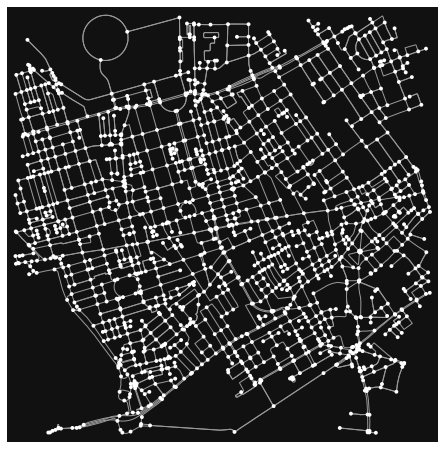

In [2]:
point = 51.515472, -0.141336 #-------------- Oxford Circus Underground tubestop

G = ox.graph.graph_from_point(point, dist=1500, simplify=True,  network_type='drive')

# If a node cannot access at least 10% of other nodes, delete it (isolated) 
remove_list = []
num_nodes = len(G.nodes)
for node in G.nodes:  
    reach = len(nx.descendants(G, node))
    if reach < num_nodes / 10:
        remove_list.append(node)

for node in remove_list:
    G.remove_node(node)

# change node labels to integers
G = nx.convert_node_labels_to_integers(G, label_attribute='old_node_ID')
ox.plot_graph(G);

In [3]:
### Use freeflow travel time as backup in case travel time not available in Uber data
G = ox.add_edge_speeds(G)
G = ox.speed.add_edge_travel_times(G, precision=1)

In [33]:
# Use Uber Movement data to get average speed for all ways during each hour of the average weekday
speed_df = pd.read_csv('data\movement-speeds-quarterly-by-hod-london-2020-Q1.csv') # downloaded from Uber Movement
speed_df_1 = speed_df.groupby(["osm_way_id", "hour_of_day"]).mean().reset_index()


In [34]:
speed_df_2 = speed_df_1[['osm_way_id', 'hour_of_day', 'speed_mph_mean']]
speed_df_2['speed'] = (speed_df_2['speed_mph_mean'] * 1.60934).round(1)

C:\Users\MATTIA~1.FIC\AppData\Local\Temp/ipykernel_3888/4230239843.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  speed_df_2['speed'] = (speed_df_2['speed_mph_mean'] * 1.60934).round(1)


In [35]:
speed_df_3 = speed_df_2[(speed_df_2['hour_of_day'] >= 8) & (speed_df_2['hour_of_day'] <= 19)].reset_index(drop = True) #---- GP practice opening times 
speed_df_3 = speed_df_3.drop('speed_mph_mean', axis = 1)

In [37]:
speed_df_4 = speed_df_3[speed_df_3['osm_way_id'] ==  232727492]
speed_df_4

,osm_way_id,hour_of_day,speed
640213,232727492,8,18.0
640214,232727492,9,18.5
640215,232727492,10,17.6
640216,232727492,11,17.1
640217,232727492,12,17.0
640218,232727492,13,17.1
640219,232727492,14,17.2
640220,232727492,15,17.0
640221,232727492,16,16.4
640222,232727492,17,16.3


In [60]:
# Convert to dictionary with way IDs and hour of the day as keys
speed_dict = dict([((t.osm_way_id, t.hour_of_day), t.speed) for t in speed_df_2.itertuples()])

In [64]:
#### ----- I am heree 

hour_choice = 12
for edge in G.edges:
    edge_obj = G[edge[0]][edge[1]][edge[2]]
    wayid = edge_obj['osmid']
    try:
        speed = speed_dict[(wayid,hour_choice)] ##------example 
        distance = edge_obj['length'] / 1000 # Convert from m to km
        travel_time = distance / speed * 60 # Convert from hours to minutes
    except:
        travel_time = edge_obj['travel_time'] / 60 # Convert from seconds to minutes
    G[edge[0]][edge[1]][edge[2]]['um_travel_time'] = travel_time


In [65]:

for edge in G.edges:
    edge_obj = G[edge[0]][edge[1]][edge[2]]
    print(edge_obj)


{'osmid': 129375498, 'name': 'Outer Circle', 'highway': 'unclassified', 'maxspeed': '20 mph', 'access': 'permissive', 'oneway': False, 'length': 19.391, 'speed_kph': 32.2, 'travel_time': 2.2, 'um_travel_time': 0.028656650246305412}
{'osmid': 129375498, 'name': 'Outer Circle', 'highway': 'unclassified', 'maxspeed': '20 mph', 'access': 'permissive', 'oneway': False, 'length': 63.845, 'speed_kph': 32.2, 'travel_time': 7.1, 'um_travel_time': 0.09435221674876847}
{'osmid': 4257258, 'oneway': True, 'name': 'Cambridge Terrace', 'highway': 'residential', 'maxspeed': '20 mph', 'access': 'permissive', 'length': 102.544, 'geometry': <shapely.geometry.linestring.LineString object at 0x00000277A84342E0>, 'speed_kph': 32.2, 'travel_time': 11.5, 'um_travel_time': 0.19166666666666668}
{'osmid': 204647020, 'name': 'York Gate', 'highway': 'unclassified', 'maxspeed': '20 mph', 'access': 'permissive', 'oneway': False, 'length': 8.052, 'speed_kph': 32.2, 'travel_time': 0.9, 'um_travel_time': 0.0244}
{'osmi

In [ ]:
# Convert to dictionary with way IDs and hour of the day as keys
speed_dict = dict([((t.osm_way_id, t.hour_of_day), t.speed) for t in speed_df_2.itertuples()])

# Append the distance / speed of each edge in the graph to the graph properties as travel time-um
hour_choice = 12
for edge in G.edges:
    edge_obj = G[edge[0]][edge[1]][edge[2]]
    wayid = edge_obj['osmid']
    try:
        speed = speed_dict[wayid][hour_choice]
        distance = edge_obj['length'] / 1000 # Convert from m to km
        travel_time = distance / speed * 60 # Convert from hours to minutes
    except:
        travel_time = edge_obj['travel_time'] / 60 # Convert from seconds to minutes
    G[edge[0]][edge[1]][edge[2]]['um_travel_time'] = travel_time

In [39]:

for edge in G.edges:
    edge_obj = G[edge[0]][edge[1]][edge[2]]
    print(edge_obj)


{'osmid': 129375498, 'name': 'Outer Circle', 'highway': 'unclassified', 'maxspeed': '20 mph', 'access': 'permissive', 'oneway': False, 'length': 19.391, 'speed_kph': 32.2, 'travel_time': 2.2, 'um_travel_time': 0.03666666666666667}
{'osmid': 129375498, 'name': 'Outer Circle', 'highway': 'unclassified', 'maxspeed': '20 mph', 'access': 'permissive', 'oneway': False, 'length': 63.845, 'speed_kph': 32.2, 'travel_time': 7.1, 'um_travel_time': 0.11833333333333333}
{'osmid': 4257258, 'oneway': True, 'name': 'Cambridge Terrace', 'highway': 'residential', 'maxspeed': '20 mph', 'access': 'permissive', 'length': 102.544, 'geometry': <shapely.geometry.linestring.LineString object at 0x00000277A84342E0>, 'speed_kph': 32.2, 'travel_time': 11.5, 'um_travel_time': 0.19166666666666668}
{'osmid': 204647020, 'name': 'York Gate', 'highway': 'unclassified', 'maxspeed': '20 mph', 'access': 'permissive', 'oneway': False, 'length': 8.052, 'speed_kph': 32.2, 'travel_time': 0.9, 'um_travel_time': 0.0150000000000

In [ ]:
travel_time = edge_obj['travel_time'] 
travel_time

In [ ]:
##Get shortest paths between all nodes and store the travel time as an array.
num_nodes = len(G.nodes)
shortest_time = np.zeros((num_nodes, num_nodes))

path_generator = nx.shortest_path_length(G, weight='um_travel_time')
for origin_data in path_generator:
    origin = origin_data[0]
    dist_dict = origin_data[1]
    for destination in dist_dict:
        shortest_time[origin, destination] = dist_dict[destination]